# Importing Important libs

In [174]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as xp

import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Read data and Make some EDA

In [175]:
df = pd.read_csv('NSE-TATAGLOBAL.csv')
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


## Stock Market Chart

In [176]:
fig = go.Figure(
    data = [
        go.Candlestick(
            x = df['Date'],
            open = df['Open'],
            close = df['Close'],
            high = df['High'],
            low = df['Low'],
        )
    ]
)

fig.show()

In [177]:
# convert date to date can pd understand it.
df['Date'] = pd.to_datetime(df['Date']).astype('datetime64[ns]')

## Show how much each year have Total Trade Quantity. 

In [178]:
data = df.groupby(df['Date'].dt.year)['Total Trade Quantity'].sum()

fig = xp.pie(data, values='Total Trade Quantity', names=data.index)
fig.show()

### Show Total Trade Quantity data and How much Incrise and decrease between years in Percentage

In [179]:
d2 = data/data.sum()
d2

Date
2010    0.030018
2011    0.065745
2012    0.133321
2013    0.129764
2014    0.136697
2015    0.084987
2016    0.096454
2017    0.192893
2018    0.130122
Name: Total Trade Quantity, dtype: float64

In [180]:
prDf = pd.DataFrame(columns=["time",'value'])

rows = []

for i in range(1, d2.shape[0]):
    dif = round((d2.iloc[i] - d2.iloc[i-1]) * 100, 2)
    rows.append([f'{d2.index[i-1]} to {d2.index[i]}', dif])
    
prDf = pd.concat([prDf] + [pd.DataFrame(rows, columns=prDf.columns)])
prDf

,time,value
0,2010 to 2011,3.57
1,2011 to 2012,6.76
2,2012 to 2013,-0.36
3,2013 to 2014,0.69
4,2014 to 2015,-5.17
5,2015 to 2016,1.15
6,2016 to 2017,9.64
7,2017 to 2018,-6.28


In [181]:
data = df.groupby(df['Date'].dt.year)['Total Trade Quantity'].sum()

fig = xp.bar(data, x=data.index, y=data)
fig.update_layout(title = 'Total Trade Quantity')
fig.show()

fig = xp.bar(prDf, x='time', y='value')
fig.update_layout(title = 'Incrise and decrease between years in Percentage')
fig.show()

# Extract the Close Column to make Forcast on it.

In [182]:
close_data = df['Close']
close_data.head()

0    233.75
1    233.25
2    234.25
3    236.10
4    233.30
Name: Close, dtype: float64

In [183]:
# scale the dataset to fit more faster.
scaler = MinMaxScaler()
close_data_scaled = scaler.fit_transform(close_data.to_numpy().reshape(-1, 1))

### The training size should be 65% of the total length of the data frame, 
### the test size should be the difference between the length of the dataset and the training size.

In [184]:
training_size = int(len(close_data_scaled)*.65)
train_data, test_data = close_data_scaled[: training_size, :], close_data_scaled[training_size:, :1]

## Just plot data of train and test

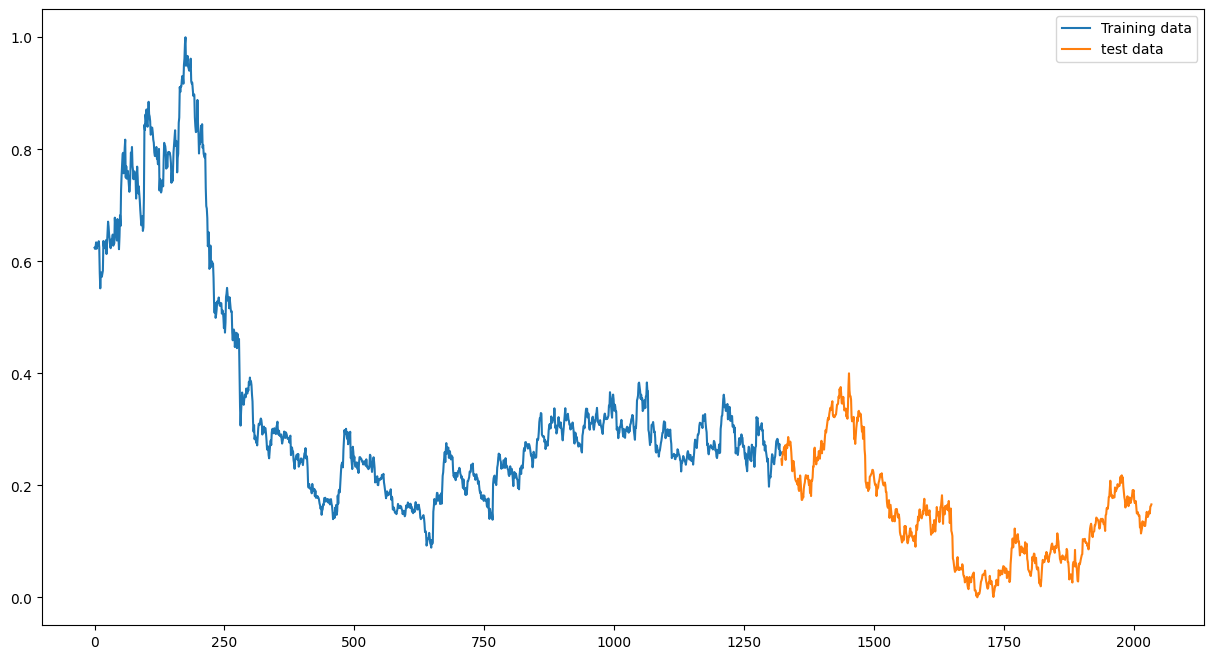

In [185]:
fig= plt.figure(figsize=(15,8))

plt.plot(train_data, label = "Training data")
# create a range of x values using linspace
x = np.linspace(len(train_data), len(close_data_scaled)-1, len(close_data_scaled)-len(train_data))

plt.plot(x, test_data, label = "test data")

plt.legend()
plt.show()

## Create Dataset
Now consider the time steps, if I want to predict the price of the stock in a day that how previous data should be considered.<br><br>
Now the timestep value will be 100. Let’s split the data X, Y. In the 0th iteration the first 100 elements goes as your <br> first record and the 101 elements will be put up in the X. The 100 elements will be put up in the Y.

In [186]:
def createDataset(data, time_step = 1):
    X, y = [], []
    limit = len(data) - time_step - 1
    
    for i in range(limit):
       X.append(data[i: (i+time_step), 0])
       y.append(data[i+time_step, 0])
    
    return np.array(X), np.array(y)

In [187]:
time_step = 100
X_train, y_train = createDataset(train_data, time_step)
X_test, y_test   = createDataset(test_data,  time_step)

# Using LSTM
While Implementing any LSTM, we should always reshape our X train in 3-D,<br> add 1 the reason behind is the time step and the 1 is given to the LSTM.

In [188]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test  = X_test.reshape (X_test.shape[0] , X_test.shape[1] , 1)

## Implementation  
we will using Sequential model and adding LSTM Layers, <br>
in the frist Layer should be time step be 1. <br>

In [198]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (100,1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer = 'adam')
model.fit(X_train, y_train, epochs=100)

Epoch 1/100
39/39 [==============================] - 6s 52ms/step - loss: 0.0128
Epoch 2/100
39/39 [==============================] - 2s 53ms/step - loss: 0.0017
Epoch 3/100
39/39 [==============================] - 2s 52ms/step - loss: 0.0015
Epoch 4/100
39/39 [==============================] - 2s 51ms/step - loss: 0.0014
Epoch 5/100
39/39 [==============================] - 2s 51ms/step - loss: 0.0013
Epoch 6/100
39/39 [==============================] - 2s 51ms/step - loss: 0.0011
Epoch 7/100
39/39 [==============================] - 2s 51ms/step - loss: 9.9623e-04
Epoch 8/100
39/39 [==============================] - 2s 51ms/step - loss: 8.9289e-04
Epoch 9/100
39/39 [==============================] - 2s 52ms/step - loss: 9.1490e-04
Epoch 10/100
39/39 [==============================] - 2s 52ms/step - loss: 9.9745e-04
Epoch 11/100
39/39 [==============================] - 2s 51ms/step - loss: 7.4030e-04
Epoch 12/100
39/39 [==============================] - 2s 52ms/step - loss: 9.1424e-04
E

In [199]:
model.evaluate(X_test, y_test)

20/20 [==============================] - 2s 21ms/step - loss: 1.3079e-04


0.00013079415657557547

In [200]:
train_predict = model.predict(X_train)
test_predict  = model.predict(X_test )

20/20 [==============================] - 0s 19ms/step


In [201]:
close_data_scaled.shape, train_predict.shape, test_predict.shape

((2035, 1), (1221, 1), (612, 1))

In [202]:
train_predict = scaler.inverse_transform(train_predict)
test_predict  = scaler.inverse_transform(test_predict )

# Final Result

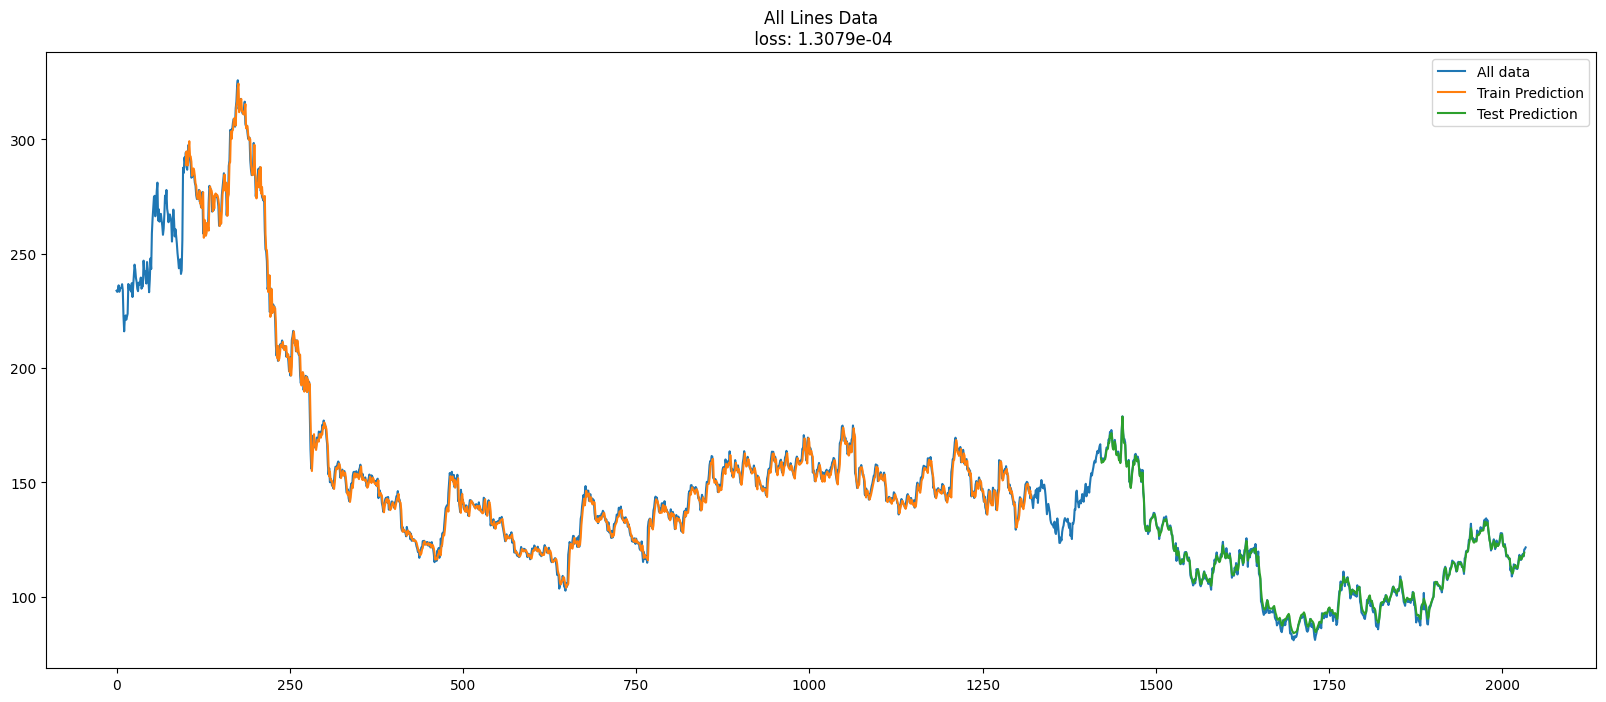

In [206]:
fig= plt.figure(figsize=(20,8))

plt.plot(close_data, label = "All data")

limi_for_pri_train = (time_step, 
                      time_step + len(train_predict))

x = range(*limi_for_pri_train)
plt.plot(x, train_predict, label = "Train Prediction")

limi_for_pri_test = (limi_for_pri_train[1] + time_step, 
                     limi_for_pri_train[1] + time_step + len(test_predict))

x = range(*limi_for_pri_test)
plt.plot(x, test_predict, label = "Test Prediction")

plt.title("All Lines Data\n loss: 1.3079e-04")
plt.legend()
plt.show()